In [ ]:
import pandas as pd

#Load data from csvs
listings_nc = "http://data.insideairbnb.com/united-states/nc/asheville/2022-12-21/data/listings.csv.gz"
listings_nc_df = pd.read_csv(listings_nc)

listings_tx = "http://data.insideairbnb.com/united-states/tx/austin/2022-12-15/data/listings.csv.gz"
listings_tx_df = pd.read_csv(listings_tx)

listings_ma = "http://data.insideairbnb.com/united-states/ma/boston/2022-12-21/data/listings.csv.gz"
listings_ma_df = pd.read_csv(listings_ma)

#We will combine the datasets now
listings_df = pd.concat([listings_nc_df, listings_tx_df, listings_ma_df])
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20604 entries, 0 to 3702
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            20604 non-null  int64  
 1   listing_url                                   20604 non-null  object 
 2   scrape_id                                     20604 non-null  int64  
 3   last_scraped                                  20604 non-null  object 
 4   source                                        20604 non-null  object 
 5   name                                          20604 non-null  object 
 6   description                                   20417 non-null  object 
 7   neighborhood_overview                         13136 non-null  object 
 8   picture_url                                   20603 non-null  object 
 9   host_id                                       20604 non-null  

In [ ]:
from pandas.core.internals.array_manager import NullArrayProxy
#Lets clean up some of the numeric and ordinal values
listings_df.head(3)

#We can remove some of these colums that dont add anything
#These include id, listing_url, scrape_id, last_scraped, source, Name, description, neighborhood_overview, picture_url, host_id, host_url, host_name, host_since, host_location, host_about, host_thumbnail_url,
# host_picture_url, host_neighbourhood, neighbourhood_cleansed, neighbourhood_group_cleansed, calendar_last_scraped
listings_df = listings_df.drop(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 
                 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 
                 'host_neighbourhood', 'neighbourhood', 'bathrooms', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'calendar_last_scraped', 'license', 'first_review', 'last_review',
                 'calendar_updated', 'property_type', 'host_verifications', 'room_type'],  axis=1)

#now lets change some of the object datatypes to float/int, ordinal or categorical
listings_df['host_acceptance_rate'] = listings_df['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0
listings_df['host_response_rate'] = listings_df['host_response_rate'].str.rstrip('%').astype('float') / 100.0
listings_df['price'] = listings_df['price'].str.replace(',', '').str.lstrip('$').astype('float')

listings_df["longitude"] = listings_df["longitude"].map(lambda x: x + 180)
listings_df["latitude"] = listings_df["latitude"].map(lambda x: x + 90)

# listings_df["room_type"] = pd.Categorical(list(listings_df['room_type'].astype('str')))
listings_df["amenities"] = listings_df["amenities"].map(lambda x: len(x))

def string_to_binary(bool_string):
    if str(bool_string) == 'f':
      return 0
    elif str(bool_string) == 't':
      return 1
    else:
      return None

listings_df['host_is_superhost'] = listings_df['host_is_superhost'].apply(string_to_binary)
listings_df['host_has_profile_pic'] = listings_df['host_has_profile_pic'].apply(string_to_binary)
listings_df['host_identity_verified'] = listings_df['host_identity_verified'].apply(string_to_binary)
listings_df['has_availability'] = listings_df['has_availability'].apply(string_to_binary)
listings_df['instant_bookable'] = listings_df['instant_bookable'].apply(string_to_binary)

listings_df['bathrooms'] = listings_df['bathrooms_text'].str.extract('(\d+)', expand=False).astype('float')
listings_df = listings_df.drop(['bathrooms_text'], axis=1)

listings_df['host_response_time'] = listings_df['host_response_time'].map(lambda x: {'a few days or more': 0, 'within a day': 1, 'within a few hours': 2, 'within an hour': 3}.get(x, 0))

listings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20604 entries, 0 to 3702
Data columns (total 45 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_response_time                            20604 non-null  int64  
 1   host_response_rate                            15930 non-null  float64
 2   host_acceptance_rate                          16899 non-null  float64
 3   host_is_superhost                             20547 non-null  float64
 4   host_listings_count                           20602 non-null  float64
 5   host_total_listings_count                     20602 non-null  float64
 6   host_has_profile_pic                          20602 non-null  float64
 7   host_identity_verified                        20602 non-null  float64
 8   latitude                                      20604 non-null  float64
 9   longitude                                     20604 non-null  

Missing values count: 42867


<Axes: >

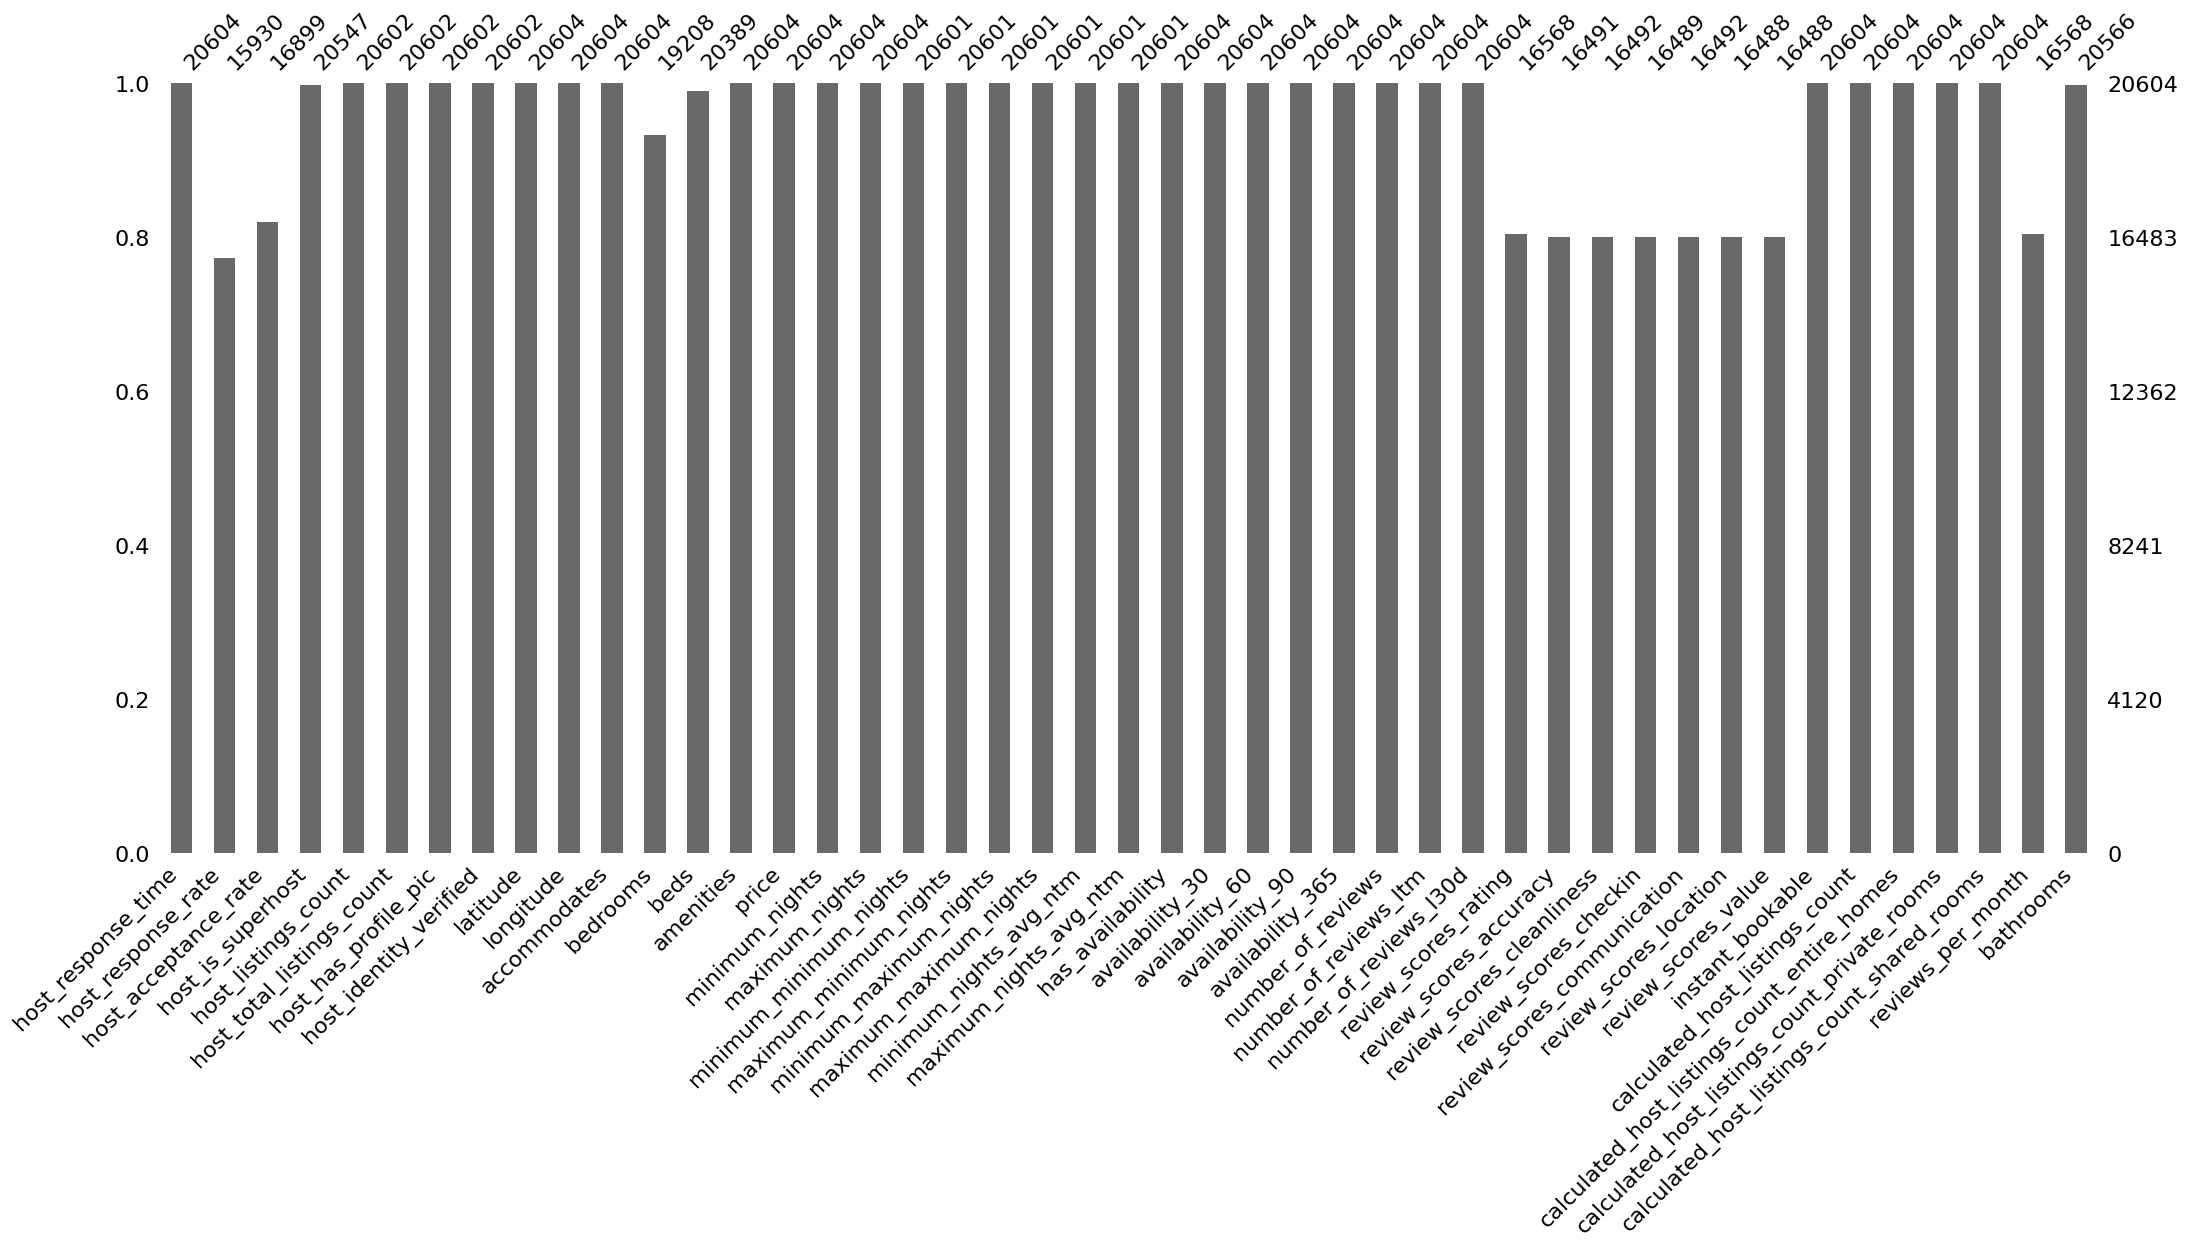

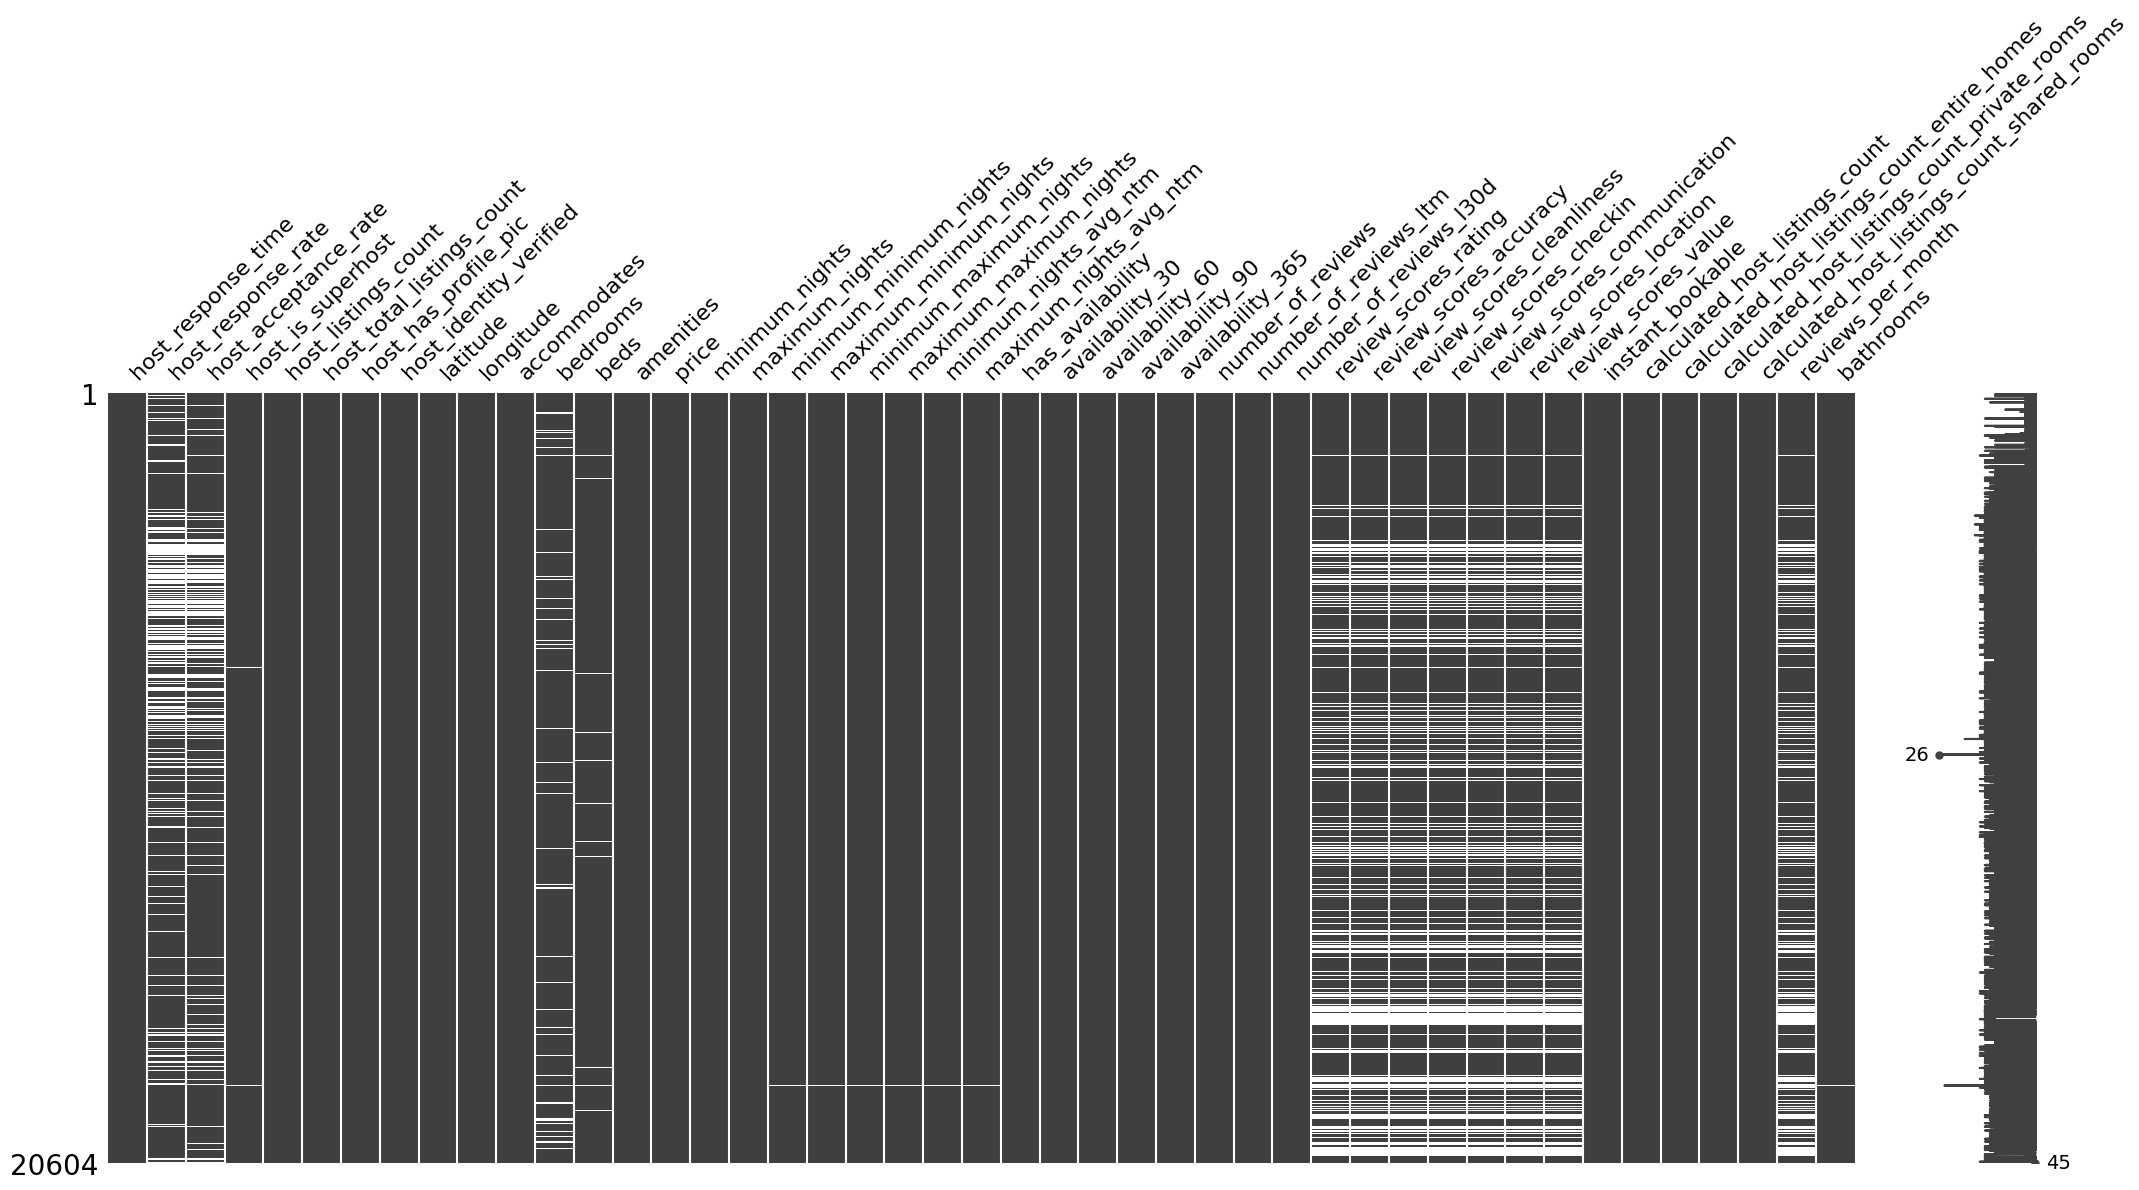

In [ ]:
import missingno as msno
#Next we will start looking at the data

#Lets look at our missing/null values
print(f'Missing values count: {listings_df.isnull().values.sum()}')

msno.bar(listings_df)
msno.matrix(listings_df)

In [ ]:
#Next lets look at the datas scewdness
import plotly.express as px
from scipy.stats import skew, norm
from scipy import stats
import matplotlib.pyplot as plt
fig = px.box(listings_df, y = 'price')
fig.show()

fig = px.histogram(listings_df, x = 'price')
fig.show()

<ipython-input-7-9f0e5a196e67>:10: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




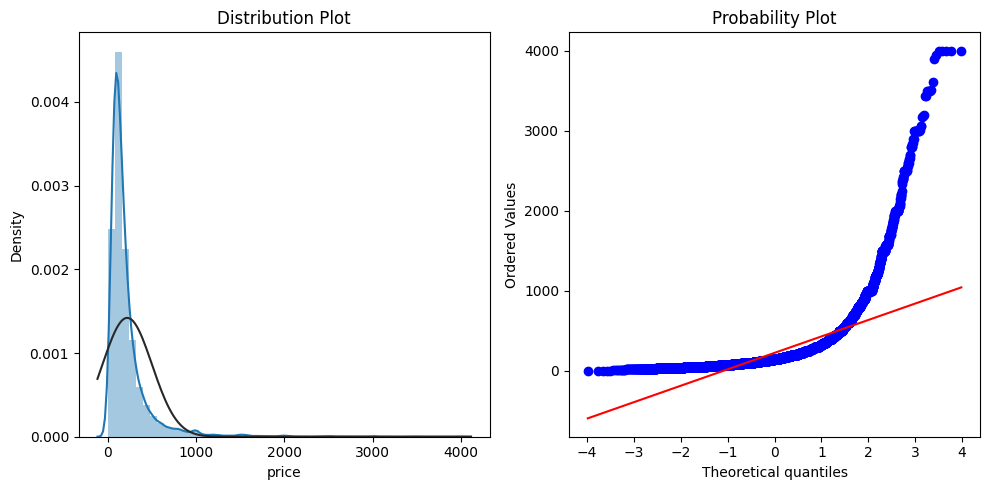

In [ ]:
import seaborn as sns
skewness = listings_df.skew().sort_values(ascending=False)
skewness[abs(skewness) > 1]

listings_df = listings_df.drop(listings_df[listings_df['price'] > 4000].index)

def normality_plot(X):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    sns.distplot(X, fit=norm, ax=axes[0])
    axes[0].set_title('Distribution Plot')

    axes[1] = stats.probplot((X), plot=plt)
    plt.tight_layout()

normality_plot(listings_df['price'])

<ipython-input-7-9f0e5a196e67>:10: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




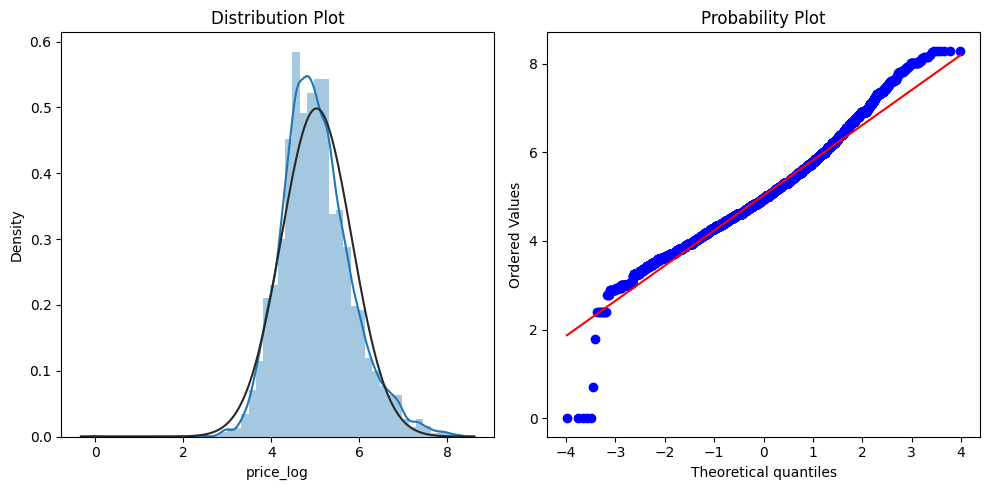

In [ ]:
# deal with the skewness issue
import numpy as np
listings_df['price_log'] = np.log(1 + listings_df['price'])
normality_plot(listings_df['price_log'])

# List of skewed columns
skewed_cols = list(skewness[abs(skewness) > 1].index)

# Remove 'MSSubClass' and 'SalePrice'
skewed_cols = [
    col for col in skewed_cols if col not in ['price','price_log']
]

# Log-transform skewed columns
for col in skewed_cols:
    listings_df[col] = np.log(1 + listings_df[col])

<Axes: >

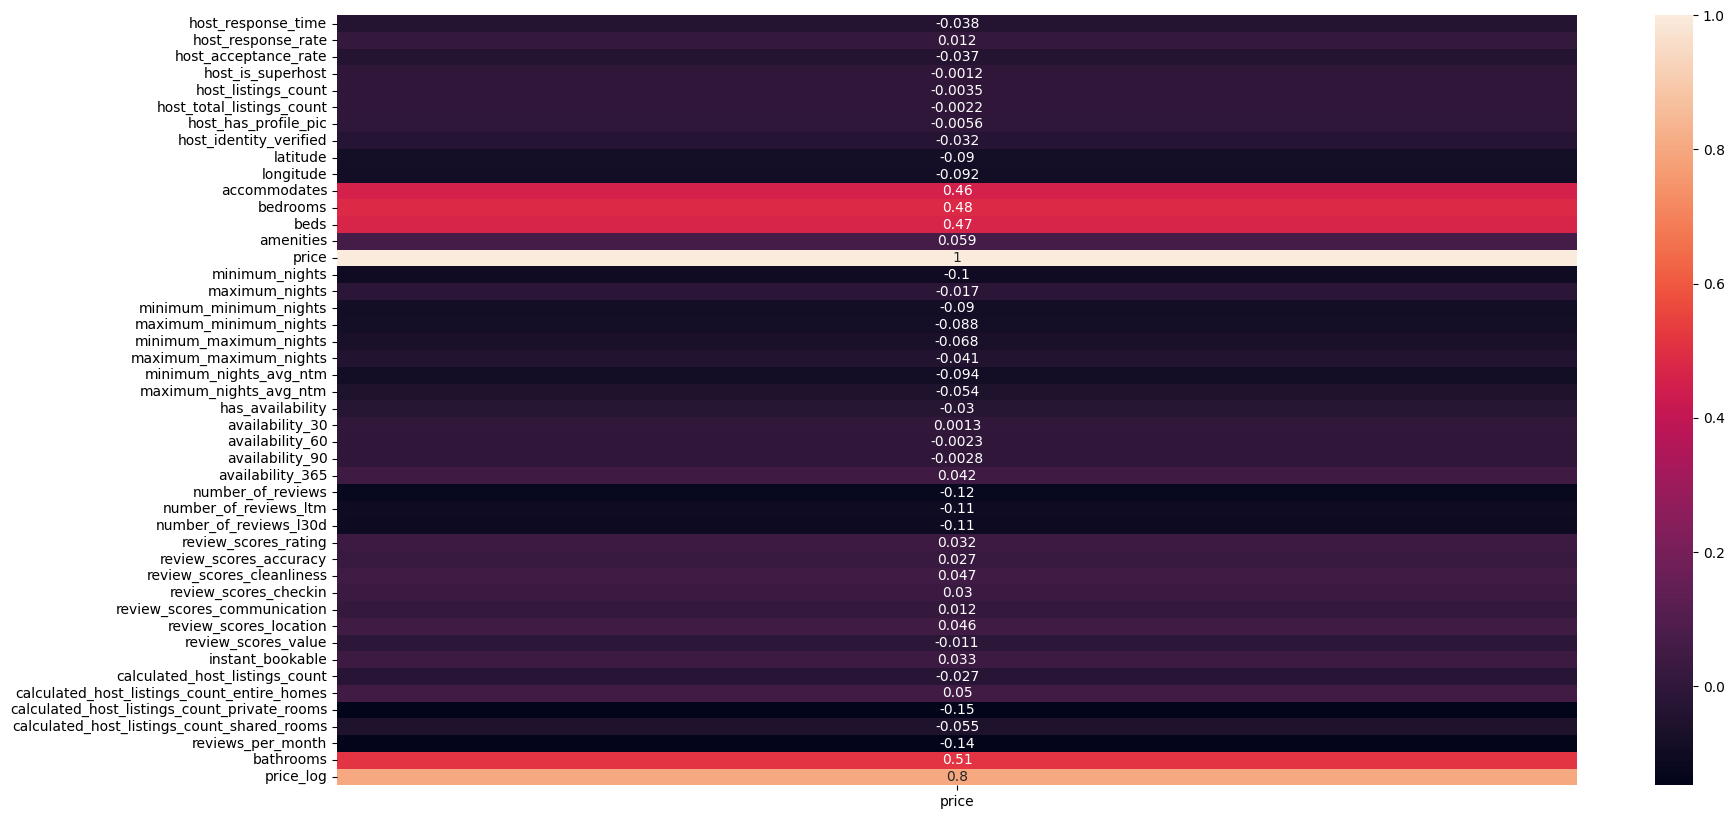

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(20, 10))
corr = listings_df.corr()[['price']]
sns.heatmap(corr, annot=True)

<Axes: >

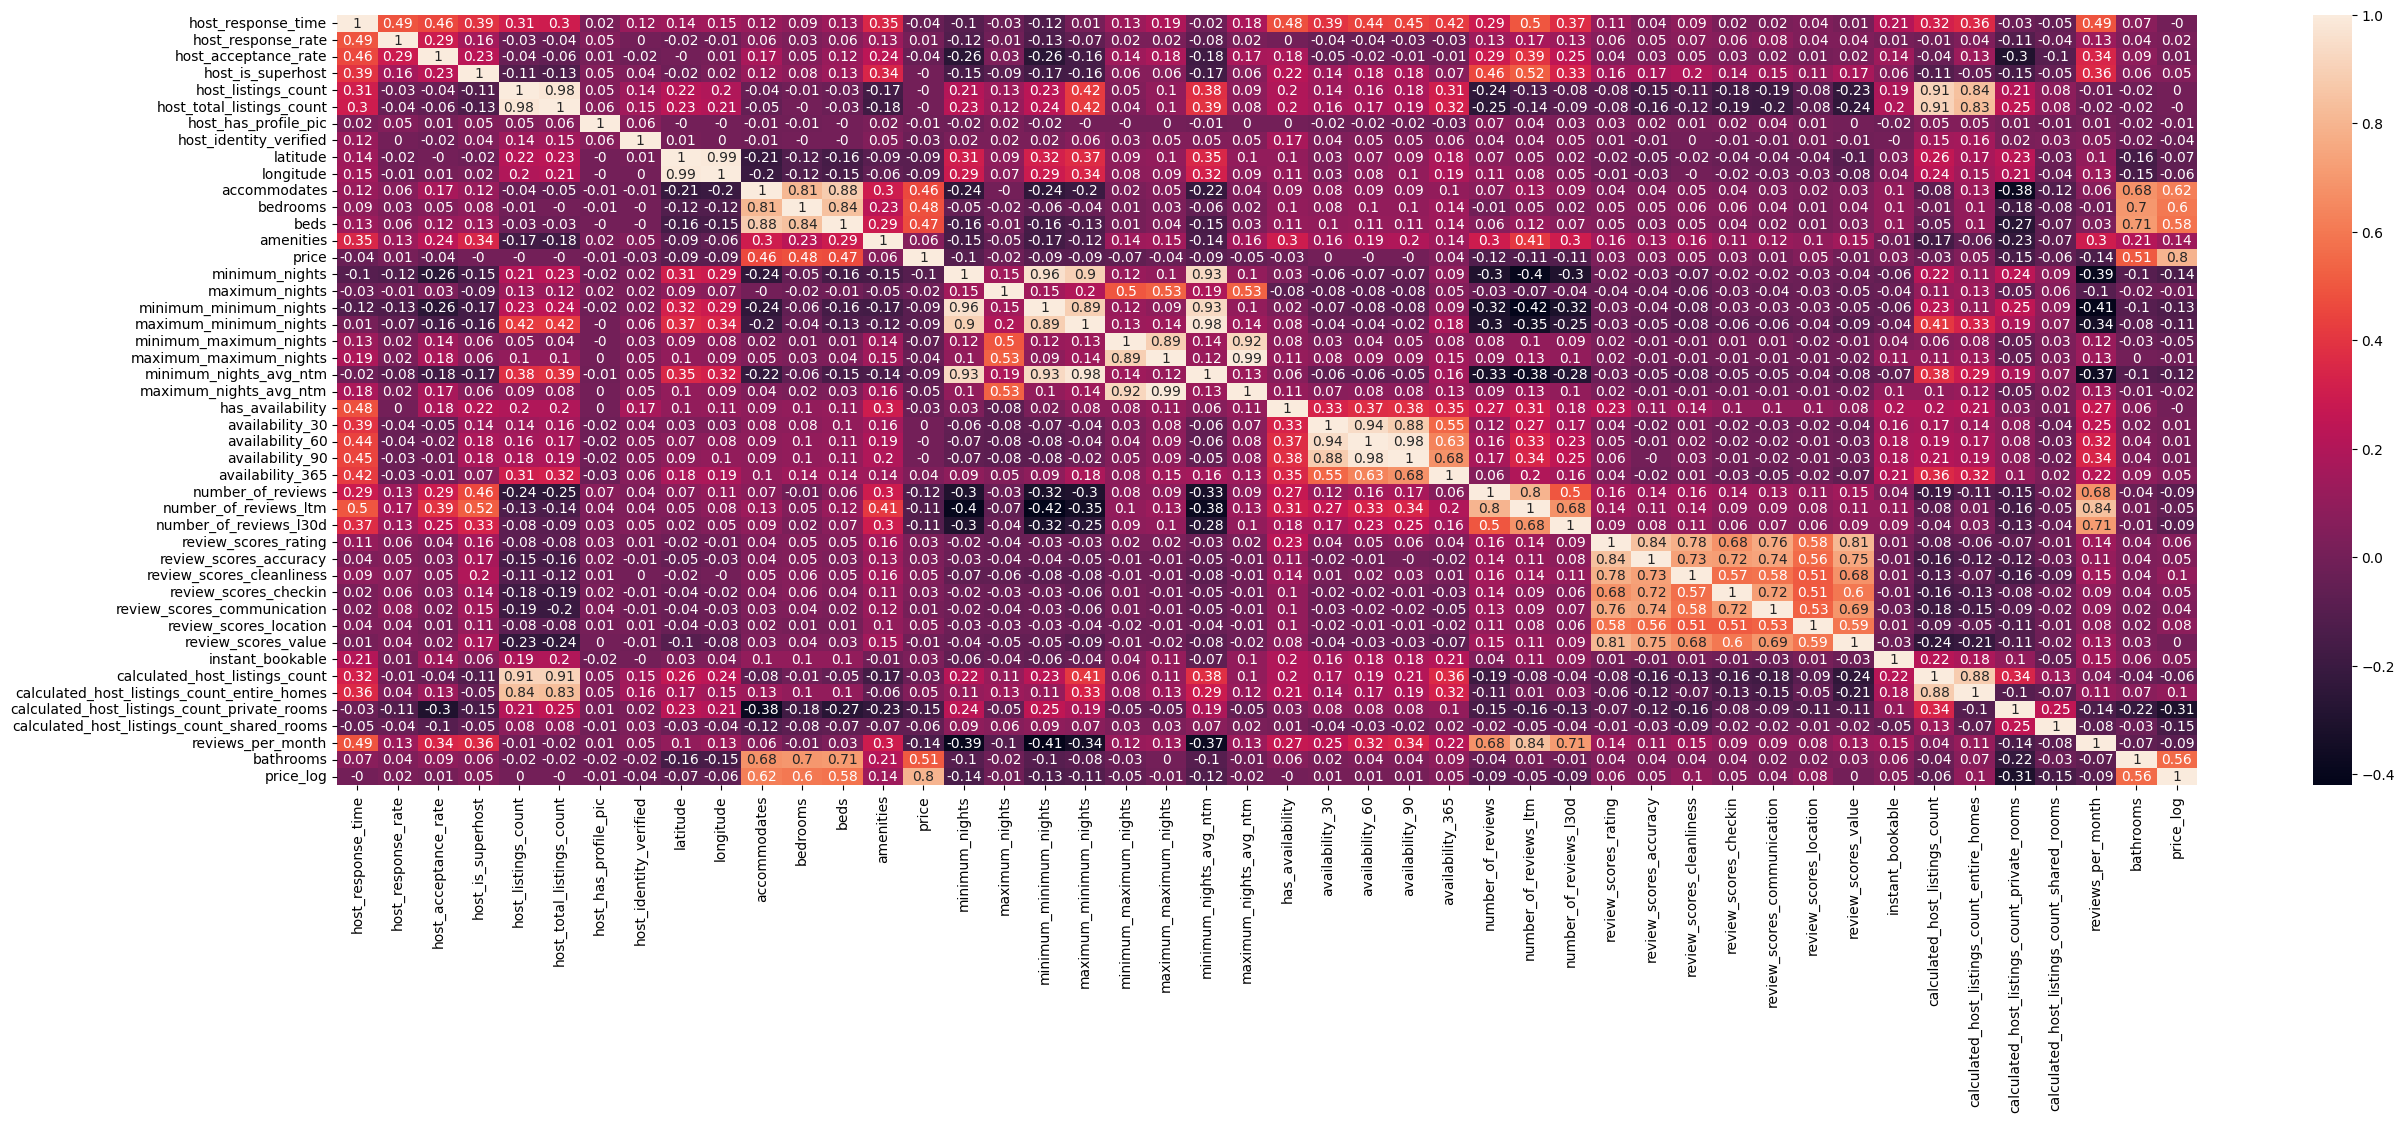

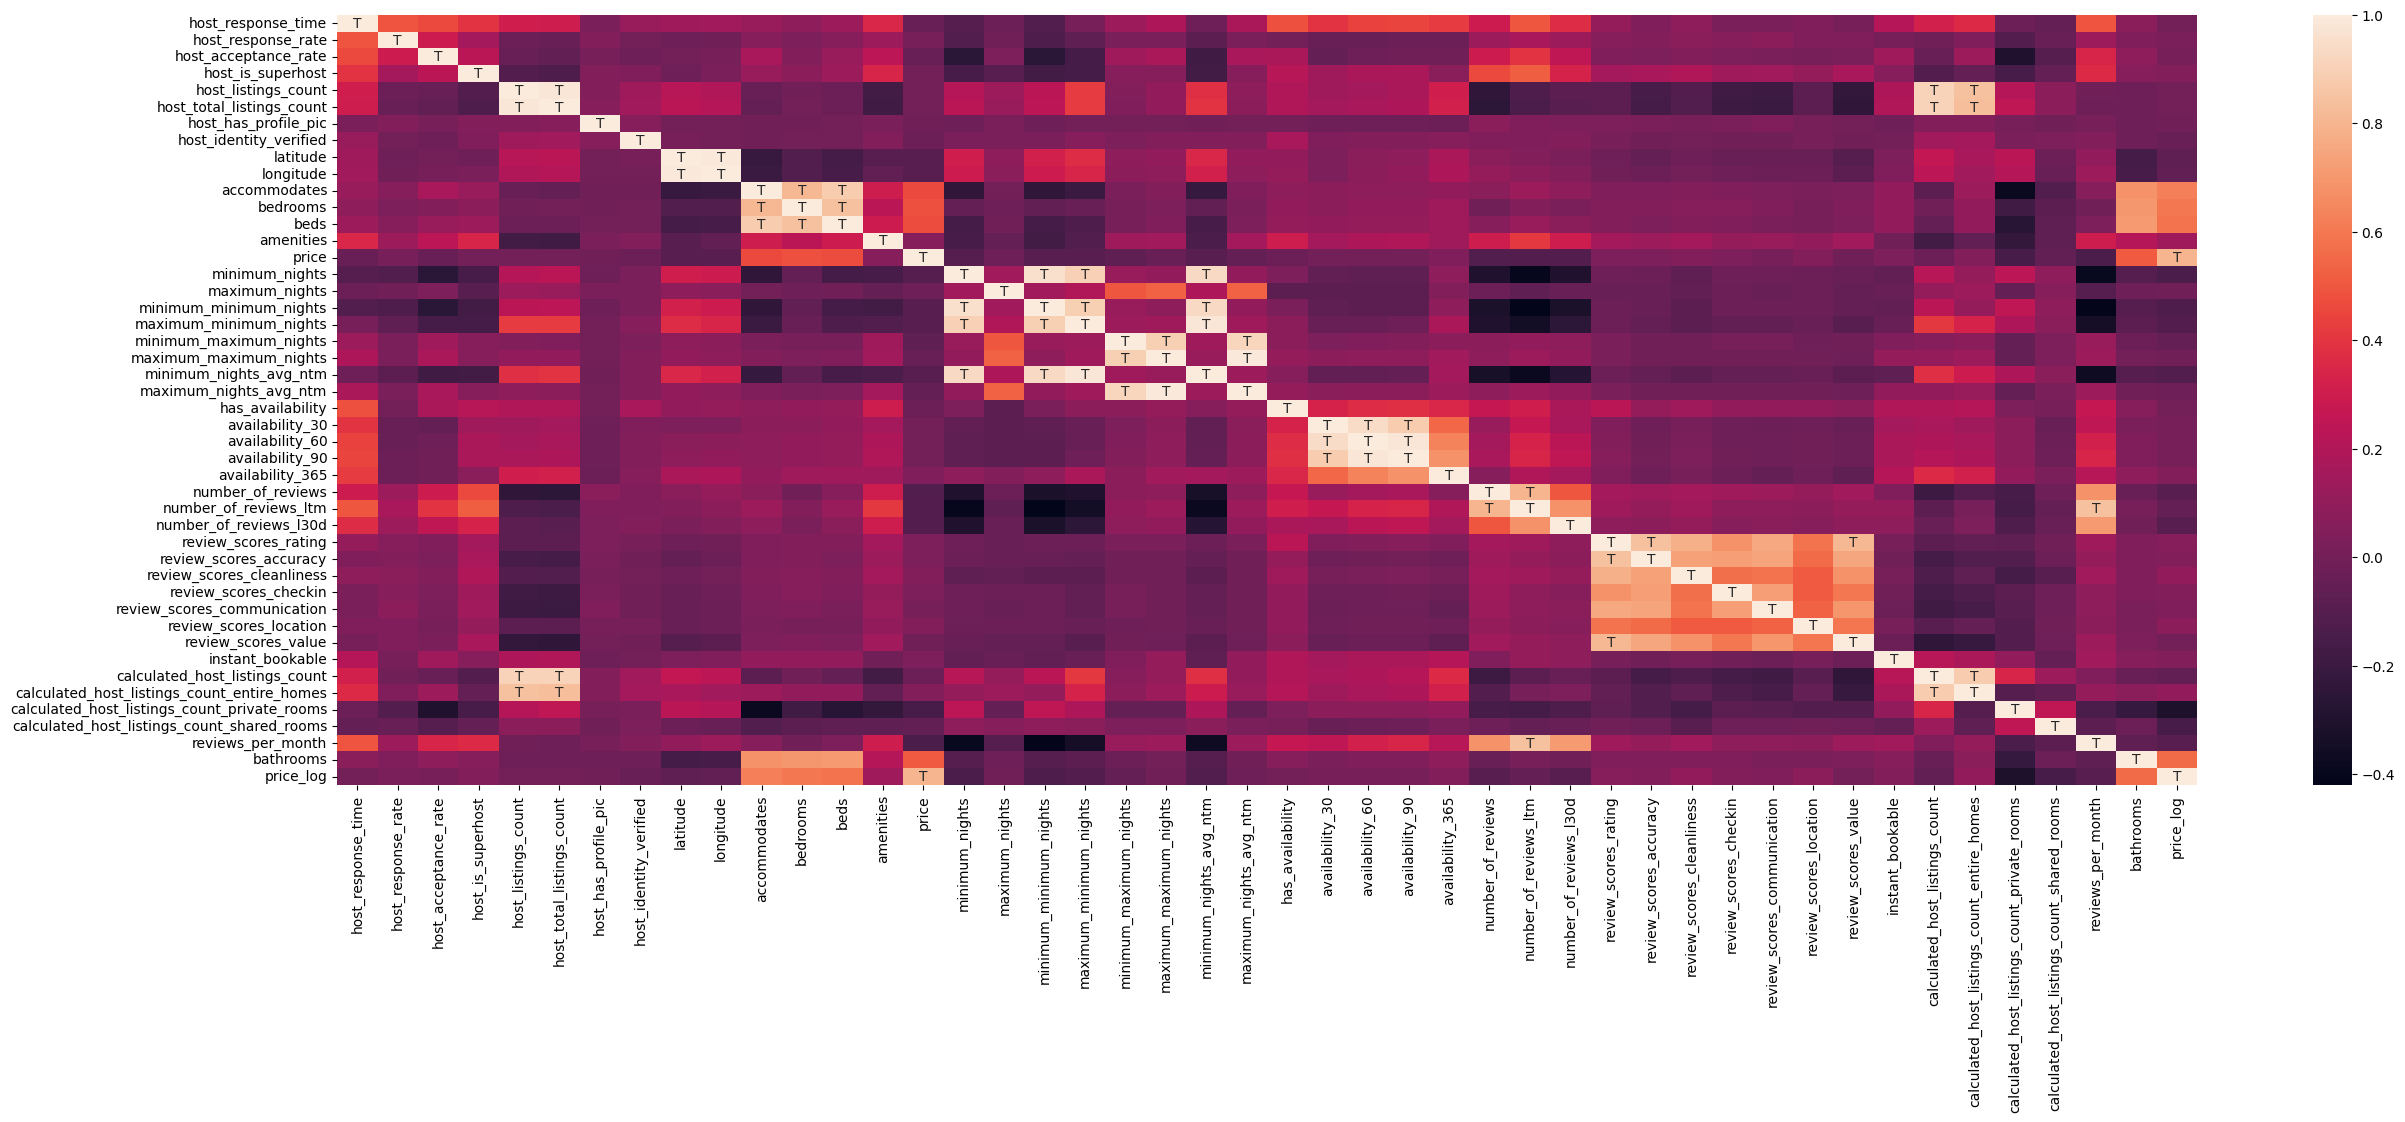

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10))
cor_df = listings_df.corr(method = "pearson").round(2)
sns.heatmap(cor_df, ax=ax, annot=True)

annot_labels = np.empty_like(cor_df, dtype=str)
annot_mask = cor_df >= 0.8
annot_labels[annot_mask] = 'T' 
fig, ax = plt.subplots(figsize=(30, 10))
sns.heatmap(cor_df, annot=annot_labels, fmt='')

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
listings_df["price"] = listings_df["price"].replace(0, np.NaN)

listings_df = listings_df.fillna(listings_df.mean())
# listings_df = listings_df.dropna()

# Separating X and y
X = listings_df.drop('price', axis=1)
Y = listings_df.price

In [ ]:
# Log Transform
def log_transfer(X_train, X_test):
    skewness = X_train.skew().sort_values(ascending=False)
    skewed_cols = list(skewness[abs(skewness) > 1].index)
    
    # Log-transform skewed columns
    for col in skewed_cols:
        X_train[col] = np.log(1 + X_train[col])
        X_test[col] = np.log(1 + X_test[col])

# Scaling
def feature_scaling(X_train, X_test):
    scaler = StandardScaler()
    numerical_cols = list(X_train.select_dtypes(exclude=['object', 'category']).columns)
    scaler.fit(X_train[numerical_cols])
    X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])   
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

log_transfer(X_train, X_test)
feature_scaling(X_train, X_test)

In [ ]:
# Building the model
from IPython.display import SVG

from keras import models, layers, optimizers, regularizers
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import model_to_dot

nn = models.Sequential()
nn.add(layers.Dense(32, input_shape=(X_train.shape[1],), activation='relu'))
# nn.add(layers.Dropout(0.1))
nn.add(layers.Dense(16, activation='relu'))
# nn.add(layers.Dropout(0.1))
nn.add(layers.Dense(8, activation='relu'))
# nn.add(layers.Dropout(0.1))
nn.add(layers.Dense(4, activation='relu'))
# nn.add(layers.Dropout(0.1))
nn.add(layers.Dense(1, activation='linear'))

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)

# Compiling the model
nn.compile(loss='mean_squared_error',
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=['mean_squared_error']) 

# Model summary
nn.summary()

# Visualising the neural network
# SVG(model_to_dot(nn2, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
# Training the model

history = nn.fit(X_train, Y_train, epochs=1000, batch_size=512, validation_split = 0.1, verbose=1, callbacks=[early_stop])

Epoch 1/500
231/231 [==============================] - 2s 10ms/step - loss: 7627.2593 - mean_squared_error: 7627.2593 - val_loss: 47060.5820 - val_mean_squared_error: 47060.5820
Epoch 2/500
231/231 [==============================] - 1s 5ms/step - loss: 7311.3086 - mean_squared_error: 7311.3086 - val_loss: 45616.4492 - val_mean_squared_error: 45616.4492
Epoch 3/500
231/231 [==============================] - 1s 5ms/step - loss: 6981.2676 - mean_squared_error: 6981.2676 - val_loss: 46524.5859 - val_mean_squared_error: 46524.5859
Epoch 4/500
231/231 [==============================] - 1s 5ms/step - loss: 7032.0244 - mean_squared_error: 7032.0244 - val_loss: 47652.7500 - val_mean_squared_error: 47652.7500
Epoch 5/500
231/231 [==============================] - 1s 5ms/step - loss: 6576.8467 - mean_squared_error: 6576.8467 - val_loss: 47701.6797 - val_mean_squared_error: 47701.6797
Epoch 6/500
231/231 [==============================] - 2s 9ms/step - loss: 5852.7739 - mean_squared_error: 5852.77

In [ ]:
def accuracy(y_true, y_pred):
    ape = np.mean(100 * np.abs(y_true - y_pred) / y_true)
    return 100 - ape

In [ ]:
print('The average difference is: ', accuracy(TestingData['Price'], TestingData['PredictedPrice']))

In [ ]:
batch_sizes = [128, 256, 512, 1024]
# epochs = [100, 200, 500, 1000]
learning_rates = [0.001, 0.003, 0.01]

best_model = None
best_accuracy = 0
best_batch_size = 0
best_epoch = 0
best_learning_rate = 0

epoch = 10

for batch_size in batch_sizes:
    # for epoch in epochs:
      for lr in learning_rates:
          nn.compile(loss='mean_squared_error',
                      optimizer=optimizers.Adam(learning_rate=lr),
                      metrics=['mean_squared_error']) 
          history = nn.fit(X_train, Y_train, epochs=epoch, batch_size=batch_size, validation_split = 0.1, callbacks=[early_stop], verbose=0)
          preds = nn.predict(X_test, verbose=0)
          TestingData = X_test.copy()
          TestingData["Price"] = Y_test
          TestingData["PredictedPrice"] = preds
          print('The average difference is: ' +  str(accuracy(TestingData['Price'], TestingData['PredictedPrice'])) + " for batch size: " + str(batch_size) + " for epoch: " + str(epoch) + " for learning rate: " + str(lr))

          if best_model is None:
              best_model = nn
              best_accuracy = accuracy(TestingData['Price'], TestingData['PredictedPrice'])
              best_batch_size = batch_size
              best_epoch = epoch
              best_learning_rate = lr
          else:
              if accuracy(TestingData['Price'], TestingData['PredictedPrice']) > best_accuracy:
                  best_model = nn
                  best_accuracy = accuracy(TestingData['Price'], TestingData['PredictedPrice'])
                  best_batch_size = batch_size
                  best_epoch = epoch
                  best_learning_rate = lr
            
print('Best model: ', best_model)
print('Best accuracy: ', best_accuracy)
print('Best batch size: ', best_batch_size)
print('Best epoch: ', best_epoch)
print('Best learning rate: ', best_learning_rate)
# Plotting the loss

NameError: ignored

In [ ]:
# Answer research questions

In [ ]:
predictions = best_model.predict(X_test)

TestingData = X_test.copy()
TestingData["Price"] = Y_test
TestingData["PredictedPrice"] = predictions

In [ ]:
overvalued = TestingData[(TestingData["Price"] - TestingData["PredictedPrice"]) / TestingData["Price"] > 0.1]
undervalued = TestingData[(TestingData["Price"] - TestingData["PredictedPrice"]) / TestingData["Price"] < -0.1]
accuratelyPriced = TestingData[abs((TestingData["Price"] - TestingData["PredictedPrice"]) / TestingData["Price"]) <= 0.1]

print("Overvalued: " + str(len(overvalued)))
print("Undervalued: " + str(len(undervalued)))
print("Accurately Priced: " + str(len(accuratelyPriced)))
print("Check sum: " + str((len(overvalued) + len(undervalued) + len(accuratelyPriced)) == len(X_test)))

overvalued["isOvervalued"] = 1
accuratelyPriced["isOvervalued"] = 0
undervalued["isOvervalued"] = 0

overvalued["isUndervalued"] = 0
accuratelyPriced["isUndervalued"] = 0
undervalued["isUndervalued"] = 1

result_df = pd.concat([overvalued, accuratelyPriced, undervalued])

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X_overval = result_df.drop(["isOvervalued", "isUndervalued", "price_log", "Price", "PredictedPrice"], axis=1) 
y_overval = result_df["isOvervalued"]

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_overval, y_overval)

In [ ]:
overval_importances = clf.feature_importances_
overval_feature_importances = pd.DataFrame({'feature': list(X_overval.columns), 'importance': importances})

In [ ]:
import matplotlib.pyplot as plt

overval_feature_importances = overval_feature_importances.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(overval_feature_importances['feature'], overval_feature_importances['importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance for Overvalued Listings')
plt.show()

In [ ]:
# Undervalued

In [ ]:
X_underval = result_df.drop(["isOvervalued", "isUndervalued", "price_log", "Price", "PredictedPrice"], axis=1) 
y_underval = result_df["isUndervalued"]

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_underval, y_underval)

In [ ]:
underval_importances = clf.feature_importances_
underval_feature_importances = pd.DataFrame({'feature': list(X_underval.columns), 'importance': importances})

In [ ]:
underval_feature_importances = underval_feature_importances.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(underval_feature_importances['feature'], underval_feature_importances['importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance for Undervalued Listings')
plt.show()